In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# Load example data
data_df = mavenn.load_example_dataset('sortseq_full-wt')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 10,269
training + validation N: 40,249


,set,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,x
0,validation,2,0,0,0,0,0,0,0,0,0,AATTGATGTCCGGTAGCTCACTCATTAGGCAGCCAAGGTTTTAGAC...
1,training,0,0,0,1,0,0,0,0,0,0,AATTCATGTGAGTTATGTCTCTCATTAGGCACCCCAGGCTTGAGAT...
2,training,1,0,0,0,0,0,0,0,0,0,AATTAATGTGAGTTAGCTCACTCATTGGACACCCCAGGCTTTACAC...
3,training,0,1,0,0,0,0,0,0,0,0,ACTTAATAAAAGTCAGCTCACTCATTAATCACCCCACGCTCTACAT...
4,training,0,0,0,0,0,3,0,0,0,0,AATTAATGTGAGTTATCTAACTCATTAGGCACCCCAGGCTTTACAC...
5,training,0,0,0,0,0,0,0,0,1,0,AATTAATGTGAGTTAGCTCACTCATTAGGCCCCCAAGTCTTTACAC...
6,training,0,0,0,0,0,0,0,0,0,2,AATTAGTGTGAGTTGCCTCACACATTAGGCACGCCAGGCTTTACAC...
7,training,0,0,0,0,0,0,0,0,1,0,TATTAATTTGACTTAGCTCACTGATTCGGTACCCTAAGCTTTATAC...
8,training,0,1,0,0,0,0,0,0,0,0,AATTAATGTGAGGTACTTCATTTATGAGGCACCCCAGGCTTTACTC...
9,training,0,1,0,0,0,0,0,0,0,0,AATTAATCTGAGTTATTTTACTCATAAGGCACCCCAGGATTTACAC...


In [3]:
# Comptue sequence length and number of bins
L = len(data_df['x'][0])
y_cols = data_df.columns[1:-1]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=75, Y=10


In [4]:
from mavenn.src.layers.gpmap import CustomGPMapLayer


# Tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Layer, Dense

class CustomAdditiveGPMapLayer(CustomGPMapLayer):
    """Represents an additive G-P map."""

    def __init__(self, L,C,theta_regularizer, *args, **kwargs):
        
        self.L=L
        self.C=C
        self.regularizer = tf.keras.regularizers.L2(theta_regularizer)
        """Construct layer instance."""
        super().__init__(*args, **kwargs)

    def build(self, input_shape):
        """Build layer."""
        # Define theta_0
        self.theta_0 = self.add_weight(name='theta_0',
                                       shape=(1,),
                                       initializer=Constant(0.),
                                       trainable=True,
                                       regularizer=self.regularizer)

        # Define theta_lc parameters
        theta_lc_shape = (1, self.L, self.C)
        theta_lc_init = np.random.randn(*theta_lc_shape)/np.sqrt(self.L)
        self.theta_lc = self.add_weight(name='theta_lc',
                                        shape=theta_lc_shape,
                                        initializer=Constant(theta_lc_init),
                                        trainable=True,
                                        regularizer=self.regularizer)
        # Call superclass build
        super().build(input_shape)

    def call(self, x_lc):
        """Process layer input and return output."""
        # Shape input
        x_lc = tf.reshape(x_lc, [-1, self.L, self.C])

        phi = self.theta_0 + \
              tf.reshape(K.sum(self.theta_lc * x_lc, axis=[1, 2]),
                         shape=[-1, 1])
        
        return phi

    def set_params(self, theta_0=None, theta_lc=None):
        """
        Set values of layer parameters.

        Parameters
        ----------
        theta_0: (float)

        theta_lc: (np.ndarray)
            Shape (L,C)

        Returns
        -------
        None
        """
        # Check theta_0
        if theta_0 is not None:
            check(isinstance(theta_0, float),
                  f'type(theta_0)={theta_0}; must be float')

        # Check theta_lc
        if theta_lc is not None:
            check(isinstance(theta_lc, np.ndarray),
                  f'type(theta_lc)={theta_lc}; must be np.ndarray')
            check(theta_lc.size == self.L * self.C,
                   f'theta_lc.size={repr(theta_lc.size)}; '
                   f'must be ({self.L * self.C}).')
            theta_lc = theta_lc.reshape([1, self.L, self.C])

        # Set weight values
        self.set_weights([np.array([theta_0]), theta_lc])

    def get_params(self):
        """
        Get values of layer parameters.

        Parameters
        ----------
        None.

        Returns
        -------
        param_dict: (dict)
            Dictionary containing model parameters. Model parameters are
            returned as matrices, NOT as individual named parameters, and are
            NOT gauge-fixed.
        """
        # Get list of weights
        param_list = self.get_weights()

        #  Fill param_dict
        param_dict = {}
        param_dict['theta_0'] = param_list[0]
        param_dict['theta_lc'] = param_list[1].reshape([self.L, self.C])

        return param_dict

In [5]:
gpmap_kwargs = {'L':L,'C':4,'theta_regularizer':0.1}

In [6]:
# Create model
model = mavenn.Model(L=L, 
                     Y=Y,
                     alphabet='dna', 
                     regression_type='MPA', 
                     gpmap_type='custom',
                     gpmap_kwargs=gpmap_kwargs,
                     custom_gpmap=CustomAdditiveGPMapLayer)

In [7]:
model.get_nn().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_labels_input (InputLay [(None, 310)]        0                                            
__________________________________________________________________________________________________
Sequence_only (Lambda)          (None, 300)          0           Sequence_labels_input[0][0]      
__________________________________________________________________________________________________
custom_additive_gp_map_layer (C (None, 1)            301         Sequence_only[0][0]              
__________________________________________________________________________________________________
Labels_input (Lambda)           (None, 10)           0           Sequence_labels_input[0][0]      
______________________________________________________________________________________________

In [8]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df[y_cols],
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.005,
          epochs=1000,
          batch_size=500,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=True)


N = 40,249 observations set as training data.
Using 24.7% for validation.
Data shuffled.
Time to set data: 0.854 sec.
Epoch 1/1000
61/61 [==============================] - 3s 23ms/step - loss: 1575.5205 - I_var: 0.0913 - val_loss: 1427.4994 - val_I_var: 0.3318
Epoch 2/1000
61/61 [==============================] - 0s 4ms/step - loss: 1376.5099 - I_var: 0.4627 - val_loss: 1336.9707 - val_I_var: 0.5078
Epoch 3/1000
61/61 [==============================] - 0s 4ms/step - loss: 1329.3037 - I_var: 0.4952 - val_loss: 1333.5487 - val_I_var: 0.5051
Epoch 4/1000
61/61 [==============================] - 0s 5ms/step - loss: 1330.1885 - I_var: 0.5033 - val_loss: 1324.9169 - val_I_var: 0.5187
Epoch 5/1000
61/61 [==============================] - 0s 4ms/step - loss: 1311.9753 - I_var: 0.5164 - val_loss: 1318.4623 - val_I_var: 0.5307
Epoch 6/1000
61/61 [==============================] - 0s 4ms/step - loss: 1313.5185 - I_var: 0.5310 - val_loss: 1311.5880 - val_I_var: 0.5456
Epoch 7/1000
61/61 [=========

61/61 [==============================] - 0s 3ms/step - loss: 1260.4430 - I_var: 0.6510 - val_loss: 1270.5571 - val_I_var: 0.6359
Epoch 58/1000
61/61 [==============================] - 0s 4ms/step - loss: 1248.8410 - I_var: 0.6461 - val_loss: 1265.9760 - val_I_var: 0.6460
Epoch 59/1000
61/61 [==============================] - 0s 4ms/step - loss: 1258.7188 - I_var: 0.6509 - val_loss: 1264.4880 - val_I_var: 0.6490
Epoch 60/1000
61/61 [==============================] - 0s 3ms/step - loss: 1256.6062 - I_var: 0.6501 - val_loss: 1265.6770 - val_I_var: 0.6465
Epoch 61/1000
61/61 [==============================] - 0s 3ms/step - loss: 1247.9709 - I_var: 0.6477 - val_loss: 1268.5470 - val_I_var: 0.6403
Epoch 62/1000
61/61 [==============================] - 0s 4ms/step - loss: 1254.8126 - I_var: 0.6490 - val_loss: 1265.2017 - val_I_var: 0.6473
Epoch 63/1000
61/61 [==============================] - 0s 3ms/step - loss: 1249.6334 - I_var: 0.6503 - val_loss: 1266.4972 - val_I_var: 0.6446
Epoch 64/1000

On test data:
I_var_test: 0.634 +- 0.010 bits
I_pred_test: 0.665 +- 0.010 bits


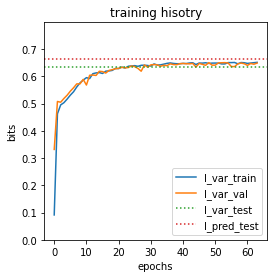

In [9]:
# Show training history
print('On test data:')
x_test = test_df['x'].values
y_test = test_df[y_cols].values

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);

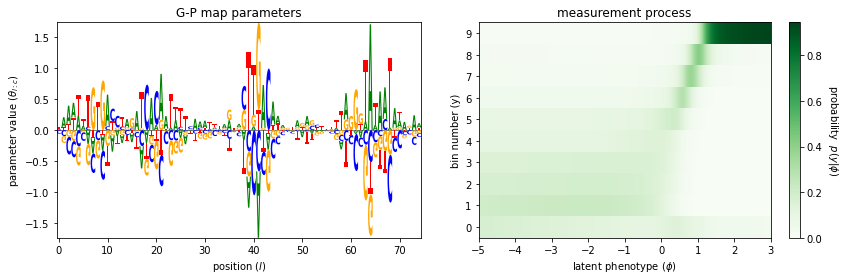

In [10]:
# Get G-P map parameters in matrix form
theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(theta['logomaker_df'], ax=ax)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
ax = axs[1]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
#fig.savefig('sortseq_g-p_map_mpa_visualization.png')
plt.show()